In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, TensorDataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm

from torchmetrics import Accuracy, F1Score, ConfusionMatrix

import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Load the MNIST dataset and split it into the train, eval, and test set

In [3]:
dataset = MNIST(root='./',
                transform=transforms.ToTensor(),
                download=True)


In [4]:
test_set = MNIST(root='./',
                train=False,
                transform=transforms.ToTensor(),
                download=True)

### Visualize data

In [5]:
%matplotlib inline
sns.set()

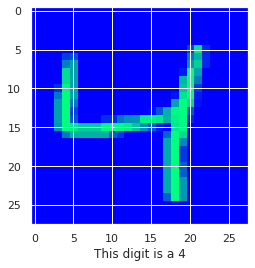

In [6]:
image = dataset[2][0][-1, :, :]
label = dataset[2][1]

plt.imshow(image, cmap='winter')
plt.xlabel(f"This digit is a {label}")
plt.show()

Actual images have white digits on a black background.

I am printing them out in color for aesthetic purposes.

In [7]:
def binary_targets(dataset):
    """
    Change the targets to binary
    In: torch dataset
    Changes the dataset inplace
    Digit 4 -> 1
    All other digits -> 0
    """
    
    dataset.targets[dataset.targets != 4] = 0
    dataset.targets[dataset.targets == 4] = 1

In [8]:
binary_targets(dataset)
binary_targets(test_set)

The available MNIST dataset does not contain a validation set.
To prevent overfitting, I will create a validation set by slicing 10 000 images off from the training set.

In [9]:
train_indices = torch.arange(0, len(dataset)-10000)
val_indices = torch.arange(len(dataset)-10000, len(dataset))
train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
print(len(train_set), len(val_set), len(test_set))

50000 10000 10000


## Create a custom multi-image dataset from MNIST

Average 10
images with standard deviation of 3, but no less than 3 and no more than 30.

In [10]:
def create_dataset_shape(size, mean=10, sd=3, low=3, upp=30):
    """
    In: desired dataset size, mean, standard deviation, lower and upper boundary
    Out: tuple of normally distributed values of the given size,
        where each item (int) is a randomly generated sequence length
    """
    
    trunc = truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    trunc_array = torch.round(torch.from_numpy(trunc.rvs(size))).int()
    trunc_list = [int(num) for num in trunc_array]
    
    return tuple(trunc_list)

In [11]:
train_shape = create_dataset_shape(4930)
val_shape = create_dataset_shape(960)
test_shape = create_dataset_shape(960)

In [12]:
assert sum(train_shape) <= len(train_set)
assert sum(val_shape) <= len(val_set)
assert sum(test_shape) <= len(test_set)

In [13]:
def split_x_and_y(dataset):
    """
    Split inputs and targets in order to modify them into a custom dataset
    In: torch dataset
    Out: inputs (torch tensor), targets (tuple)
    """

    dataset_x, dataset_y = zip(*dataset)
    dataset_x = torch.stack(list(dataset_x), dim=0)
    dataset_y = torch.tensor(dataset_y)
    return dataset_x, dataset_y

In [14]:
def custom_dataset(inputs, targets, data_shape):
    """
    In: inputs (tensor) and targets (iterable) from existing dataset;
        new desired shape of multi-image dataset
    Out: new inputs (len(shape) x max sequence length x channel x image_dim1 x image_dim2) 
        targets (len(shape))
            
    """
    max_seq_len = max(data_shape)
    size_x = (len(data_shape), max_seq_len) + tuple(inputs[0].shape)
    print(size_x)                                                   
    size_y = (len(data_shape), max_seq_len)
    print(size_y)
    
    x = torch.zeros(size_x)
    y = torch.zeros(size_y)

    line_index = 0

    for idx, dim in enumerate(data_shape):
        x[idx,0:dim] = inputs[line_index: line_index+dim]
        y[idx,0:dim] = targets[line_index: line_index+dim]
        line_index += dim

    y = torch.where(y.sum(axis=1)>=1, 1, 0)
    return x, y

In [15]:
train_x, train_y = split_x_and_y(train_set)
train_x, train_y = custom_dataset(train_x, train_y, train_shape)

(4930, 22, 1, 28, 28)
(4930, 22)


In [16]:
val_x, val_y = split_x_and_y(val_set)
val_x, val_y = custom_dataset(val_x, val_y, val_shape)

(960, 20, 1, 28, 28)
(960, 20)


In [17]:
test_x, test_y = split_x_and_y(test_set)
test_x, test_y = custom_dataset(test_x, test_y, test_shape)

(960, 19, 1, 28, 28)
(960, 19)


In [18]:
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

## Create model

In [19]:
class ImageClassifier(nn.Module):
    """
    A deep neural network for binary multi-image data classification
    In: dropout rate (small positive float)
        number of outputs of the final layer (int)
        stride for the convolutional layers (small int)
        padding for the convolutional layers (small int)
    Out: probabilistic result of the binary image classification (float)
    """
        
    def __init__(self,
                 dropout_rate,
                 n_outputs,
                 stride,
                 padding
                ):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=stride, padding=padding)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, n_outputs)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, inputs): 
        x_tmp = inputs.reshape(inputs.shape[0]*inputs.shape[1], 1, inputs.shape[3], inputs.shape[4])
        x = self.relu(self.conv1(x_tmp))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.reshape(inputs.shape[0], inputs.shape[1], 1024)
        x = x.mean(dim=1) 
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

Hyperparameters

In [20]:
n_outputs = 1
dropout_rate = 0.3
num_epochs = 20
stride = 2
padding = 1

In [21]:
model = ImageClassifier(
                        dropout_rate=dropout_rate,
                        n_outputs=n_outputs,
                        stride=stride,
                        padding=padding,
                        ).to(device)
print(model)

ImageClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Create data loaders

In [22]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle = True)

for data, labels in train_loader:
    print(data.shape)
    seq_length = data.shape[1]
    break

torch.Size([64, 22, 1, 28, 28])


## Train model

In [23]:
def train_model(train_loader=train_loader,
                val_loader=val_loader,
                model=model,
                criterion=nn.BCELoss(),
                num_epochs=num_epochs
               ):
    """
    Training loop for the model
    In: training and validation data loaders (torch DataLoader)
        model (instance of torch.nn.Module)
        criterion: loss function
        number of epochs to the model train for, int
        learning rate: small positive float value
    Out: training losses (list of floats) and validation losses (list of floats), per epoch
    """

    
    start_time = time.time()
    
    train_losses = []
    val_losses = []
    accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_loss_val = 0

        model.train()
        
        for inputs, targets in train_loader: 
            inputs = inputs.to(device=device)
            targets = targets.to(device=device)
            
            optimizer= torch.optim.Adam(model.parameters(), 
                                        lr=0.001 if epoch < num_epochs//2 else 0.0001)
            optimizer.zero_grad()
            
            
            output = model(inputs)
            loss = criterion(output.squeeze(), targets.float())
            loss.backward()

            optimizer.step()
            total_loss += loss.item()

            
        train_losses.append(total_loss/len(train_loader))
        model.eval()
        
        
        for val_inputs, val_labels in val_loader:
            val_output = model(val_inputs)
            val_loss = criterion(val_output.squeeze(), val_labels.float())
            total_loss_val += val_loss.item()
            
            
        val_losses.append(total_loss_val/len(val_loader))
    
        
        print(f"Epoch: {epoch+1}/{ num_epochs}\t",
              f"{((time.time() - start_time) / 60):.2f} min\t",
              f"Loss: {total_loss/len(train_loader):.3f}\t",
              f"Val Loss: {total_loss_val/len(val_loader):.3f}\t")
            
            
    print(f"Training completed in {(time.time() - start_time) / 60} min.")
    
    return train_losses, val_losses

In [24]:
train_losses, val_losses = train_model()

Epoch: 1/20	 0.28 min	 Loss: 0.657	 Val Loss: 0.869	
Epoch: 2/20	 0.56 min	 Loss: 0.618	 Val Loss: 0.737	
Epoch: 3/20	 0.84 min	 Loss: 0.570	 Val Loss: 0.831	
Epoch: 4/20	 1.13 min	 Loss: 0.503	 Val Loss: 0.798	
Epoch: 5/20	 1.40 min	 Loss: 0.446	 Val Loss: 1.320	
Epoch: 6/20	 1.70 min	 Loss: 0.408	 Val Loss: 0.650	
Epoch: 7/20	 2.00 min	 Loss: 0.322	 Val Loss: 0.218	
Epoch: 8/20	 2.30 min	 Loss: 0.290	 Val Loss: 0.225	
Epoch: 9/20	 2.60 min	 Loss: 0.234	 Val Loss: 0.186	
Epoch: 10/20	 2.89 min	 Loss: 0.220	 Val Loss: 0.672	
Epoch: 11/20	 3.20 min	 Loss: 0.184	 Val Loss: 0.129	
Epoch: 12/20	 3.48 min	 Loss: 0.149	 Val Loss: 0.119	
Epoch: 13/20	 3.76 min	 Loss: 0.142	 Val Loss: 0.115	
Epoch: 14/20	 4.03 min	 Loss: 0.138	 Val Loss: 0.113	
Epoch: 15/20	 4.31 min	 Loss: 0.132	 Val Loss: 0.122	
Epoch: 16/20	 4.59 min	 Loss: 0.128	 Val Loss: 0.107	
Epoch: 17/20	 4.90 min	 Loss: 0.128	 Val Loss: 0.106	
Epoch: 18/20	 5.20 min	 Loss: 0.123	 Val Loss: 0.112	
Epoch: 19/20	 5.48 min	 Loss: 0.132	 

## Evaluate the model

In [25]:
def evaluate_performance(model, data_loader):
    """
    Evaluate the model performance on the given set
    In: model, test data loader (torch DataLoader)
    Out: accuracy, F1 score, confusion matrix (torch tensors)
    """
    size = len(data_loader)
    
    model = model
    model.eval()
    
    f1 = F1Score()
    conf_mat = ConfusionMatrix(num_classes=2)
    acc = Accuracy()

    
    total_f1 = 0
    total_conf_mat = 0
    total_acc = 0

    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            output = model(inputs)
            total_f1 += f1(output.squeeze(), labels)
            total_acc += acc(output.squeeze(), labels)
            total_conf_mat += conf_mat(output.squeeze(), labels)

    
    return total_f1/size, total_acc/size, total_conf_mat

### Evaluate the model on the training and validation set

In [26]:
train_f1, train_acc, train_conf_mat = evaluate_performance(model, train_loader)
val_f1, val_acc, val_conf_mat = evaluate_performance(model, val_loader)

In [27]:
print(f"Training set: Accuracy: {float(train_acc):.3f}\t F1 Score: {float(train_f1):.3f}" )
print(f"Validation set: Accuracy: {float(val_acc):.3f}\t F1 Score: {float(val_f1):.3f}" )

Training set: Accuracy: 0.958	 F1 Score: 0.967
Validation set: Accuracy: 0.954	 F1 Score: 0.965


Plot the confusion matrices for the training and validation set

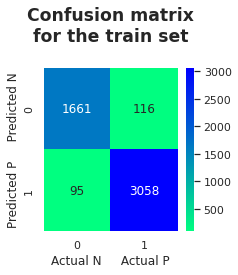

In [28]:
_ = plt.figure(figsize=(3,3))
_ = sns.heatmap(train_conf_mat.numpy(), cmap = "winter_r", annot=True, fmt='d')
_ = plt.title("Confusion matrix\nfor the train set\n", fontsize='x-large', fontweight='bold')
_ = plt.xlabel("Actual N     Actual P")
_ = plt.ylabel("Predicted P     Predicted N")
plt.show()
    
    

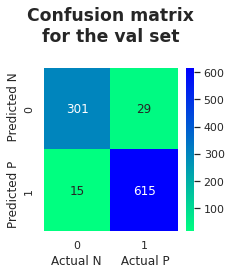

In [29]:
_ = plt.figure(figsize=(3,3))
_ = sns.heatmap(val_conf_mat.numpy(), cmap = "winter_r", annot=True, fmt='d')
_ = plt.title("Confusion matrix\nfor the val set\n", fontsize='x-large', fontweight='bold')
_ = plt.xlabel("Actual N     Actual P")
_ = plt.ylabel("Predicted P     Predicted N")
plt.show()

### Evaluate the model on the test set

In [42]:
test_f1, test_acc, test_conf_mat = evaluate_performance(model, test_loader)
print(f"Test set: Accuracy: {float(test_acc):.3f}\t F1 Score: {float(test_f1):.3f}" )

Test set: Accuracy: 0.939	 F1 Score: 0.952


Plot the confusion matrix for the test set

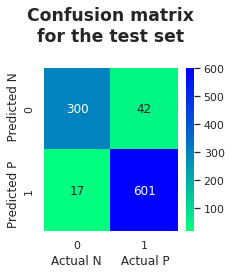

In [43]:
_ = plt.figure(figsize=(3,3))
_ = sns.heatmap(test_conf_mat.numpy(), cmap = "winter_r", annot=True, fmt='d')
_ = plt.title("Confusion matrix\nfor the test set\n", fontsize='x-large', fontweight='bold')
_ = plt.xlabel("Actual N     Actual P")
_ = plt.ylabel("Predicted P     Predicted N")
plt.show()

## Make predictions

In [44]:
def predict(data, model=model, verbose=True):
    """
    In: a data point consisting of multiple images
        of the shape (1 x seq length x 1 x 28 x 28)
        classification model (instance of torch.nn)
        if verbose: prints the images of the digits 
                    and a text message with prediction result
    Out: 1 if 4 if sequence of images contains a 4, 0 if not
    """
    
    pred_loader = torch.utils.data.DataLoader(data, batch_size=1)
    model.eval()
    
    total_output = []
    
    for x in pred_loader:
        output = model(x)
        total_output.append(output)
        
        if verbose:
            for seq in x:
                for idx, img in enumerate(seq):
                    if img.sum() > 0:
                        _ = plt.figure(figsize=(1,1))
                        _ = plt.imshow(img[-1, :, :], cmap='winter')
                        plt.show()

            print ("This sequence of images contains a 4" if output >= 0.5 \
                else "This sequence of images doesn't contain a 4")
    
    return [1  if output >= 0.5 else 0 for output in total_output]

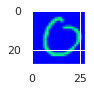

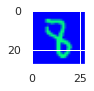

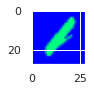

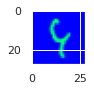

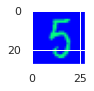

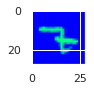

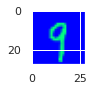

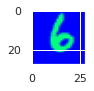

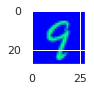

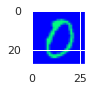

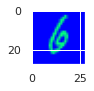

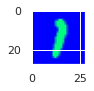

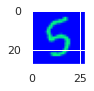

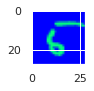

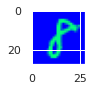

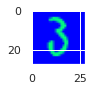

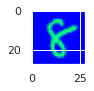

This sequence of images contains a 4


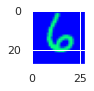

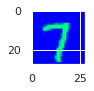

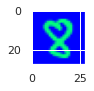

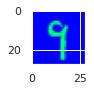

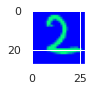

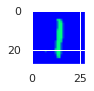

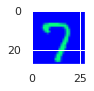

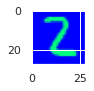

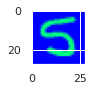

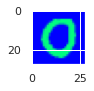

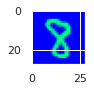

This sequence of images doesn't contain a 4


In [45]:
random_imgs = test_x[torch.randint(high=len(test_x),size=[2])]
pred = predict(random_imgs)